# **1. Szükséges csomagok betöltése**

In [210]:
import pandas as pd # Adatmanipulálás és analízálás
import numpy as np # Numerikus számításokhoz
import matplotlib.pyplot as plt # Adat vizualizációhoz
import seaborn as sns # Statisztikus adat vizualizációhoz

import scipy.stats as stats # Statisztikus elemzésekhez

from sklearn.preprocessing import OneHotEncoder # Adat előkészítés

from statsmodels.stats.diagnostic import het_breuschpagan # Heteroszkedacitás tesztelése regresszióban
from statsmodels.stats.outliers_influence import variance_inflation_factor # Multikollinearitás kimutatásához
from statsmodels.stats.stattools import durbin_watson # Autokorrelációs teszthez

import statsmodels.api as sm # Statisztikai modellek és tesztelés

from sklearn.model_selection import train_test_split # Modell értékelés és tanítás

from sklearn import metrics # Modell teljesítmény értékeléshez

from sklearn.linear_model import LinearRegression # Egy- és többváltozós regressziós modellezés
from sklearn.linear_model import Ridge # Regularizált regresszió modellezés
from sklearn.linear_model import Lasso # Jellemző kiválasztásos regresszió modellezés
from sklearn.linear_model import ElasticNet # L1 és L2 reguralizáció kombinálása

# **2. Adatok előkészítése**

## *2.1 Adatok betöltése és megjelenítése*

In [211]:
gym_data = pd.read_csv('gym_members_exercise_tracking.csv', sep = ',', header = 0)
gym_data.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


Nézzük meg, hogy hány adatot és oszlopot tartalmaz ez az adathalmazunk

In [212]:
gym_data.shape

(973, 15)

Annyi adatot tartalmaz az adathalmaz, hogy rendes elemzést tudjunk végrehajtani rajta

## *2.2 Adatok tisztaságának ellenőrzése és adatok megtisztítása*

#### *2.2.1 Üres adatok ellenőrzése*

In [213]:
gym_data.isnull().any(axis = 'rows')

Age                              False
Gender                           False
Weight (kg)                      False
Height (m)                       False
Max_BPM                          False
Avg_BPM                          False
Resting_BPM                      False
Session_Duration (hours)         False
Calories_Burned                  False
Workout_Type                     False
Fat_Percentage                   False
Water_Intake (liters)            False
Workout_Frequency (days/week)    False
Experience_Level                 False
BMI                              False
dtype: bool

Ahogy láthatjuk a fenti eredmény alapján egyik oszlopban sincsen hiányos adatot. Ellenőrizzük rá a következő részben, hogy van-e duplikált sor

In [214]:
gym_data.duplicated(keep = False).sum()

np.int64(0)

A fenti eredmény alapján láthatjuk, hogy nincsenek duplikált sorok, tehát ezzel se kell foglalkoznunk

#### *2.2.2 Outlier értékek vizsgálata*

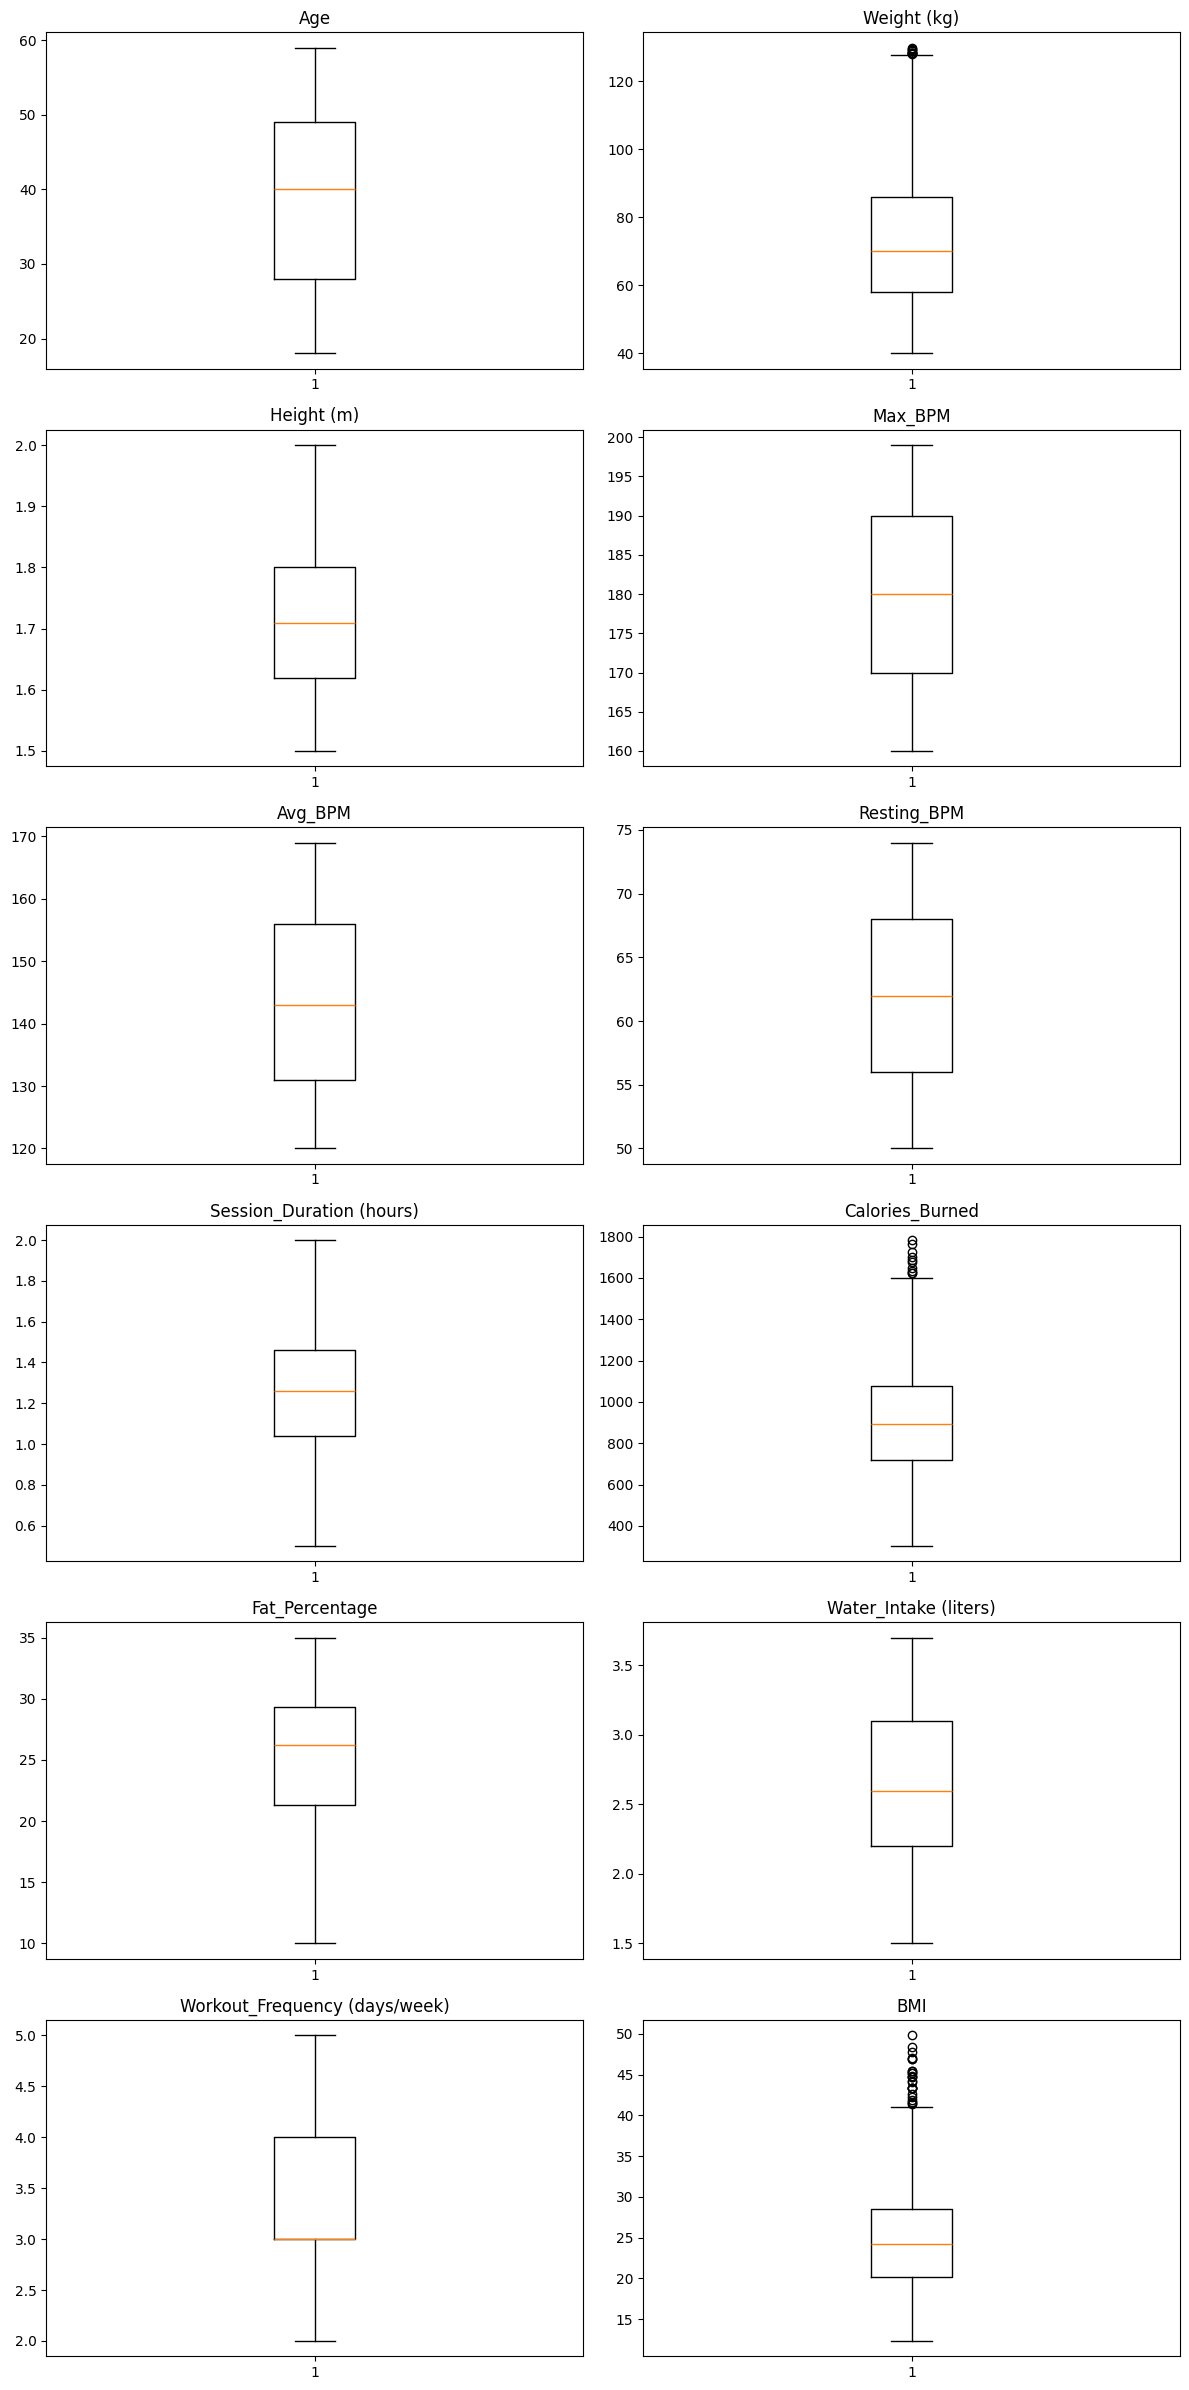

In [215]:
columns = [
    'Age',
    'Weight (kg)',
    'Height (m)',
    'Max_BPM',
    'Avg_BPM',
    'Resting_BPM',
    'Session_Duration (hours)',
    'Calories_Burned',
    'Fat_Percentage',
    'Water_Intake (liters)',
    'Workout_Frequency (days/week)',
    'BMI'
]

# A boxplotokat 6 sorba és 2 oszlopba szeretném megjeleníteni, ennek megfelelően vannak beállítva az értékek

n_rows = (len(columns) + 1) // 2 # sorok száma (egész kerekítéssel)
# matplotlib subplots függvényéből kiszedi a Figure osztályt, amivel lehet ábrázolni (de ezt a változót nem használom most), nekem a következő, amit kiad magából Axes osztály kell, 
# amivel tudok boxplotot készíteni az általam kijelölt oszlopokra. figsize paraméterben beállítom, hogy mekkora szélességgel és magassággal jelenjenek meg a dobozok
fig, axs = plt.subplots(nrows = n_rows, ncols = 2, figsize=(12, n_rows * 4)) 

# Végig iterálok az oszlopokon és mindegyiket megjelenítem külön-külön cellákban
for i, column in enumerate(columns):
    ax = axs[i // 2, i % 2] # Az első kiszámolja a sor indexet a második pedig az oszlop indexet
    ax.boxplot(gym_data[column])
    ax.set_title(column)

plt.tight_layout() # A plotok közötti tért növeli
plt.show()

Az ábrákon láthatjuk, hogy nincsenek olyan adatok az oszlopokban, amik túlzottan kívül esnének a realitás határain, tehát nem kell törölni, de regressziónál ajánlatos lenne az outlier értékeket kivenni, mert nagyban befolyásolják a kijövő modell pontosságát.

#### *2.2.3 Nem numerikus adattagokra vizsgálat*

Nézzük meg, hogy a Gender oszlopban ténylegesen csak a férfi és nő szerep van vagy van-e plusz adattagja és tegyünk kitekintést, hogy milyen edzési típusok vannak. Pluszban vizsgáljunk rá 
az Experience_Level oszlopra is, mert az egy label kódolt változó (1 - Kezdő, 2 - Haladó, 3 - Szakértő)

Gender
Male      511
Female    462
Name: count, dtype: int64


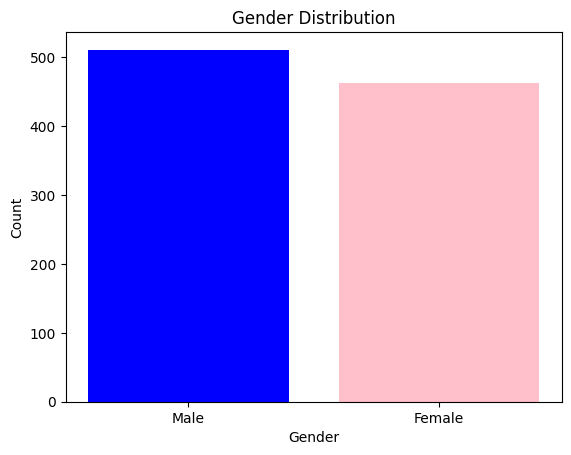

In [216]:
gender_counts = gym_data['Gender'].value_counts()
print(gender_counts)
plt.bar(gender_counts.index, gender_counts.values, color=['blue', 'pink'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.show()

A Gender oszlop csak férfi és női értékeket tartalmaz és láthatjuk, hogy közel kiegyensúlyozottan tartalmaz adatokat férfi és női adatokról

Workout_Type
Strength    258
Cardio      255
Yoga        239
HIIT        221
Name: count, dtype: int64


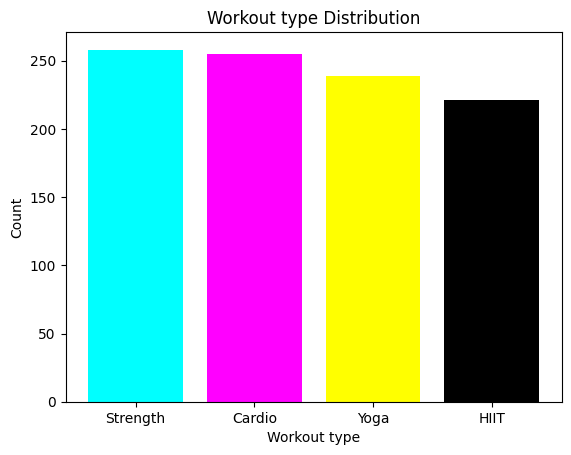

In [217]:
workout_types_counts = gym_data['Workout_Type'].value_counts()
print(workout_types_counts)
plt.bar(workout_types_counts.index, workout_types_counts.values, color=['cyan', 'magenta', 'yellow', 'black'])
plt.xlabel('Workout type')
plt.ylabel('Count')
plt.title('Workout type Distribution')
plt.show()

Az adathalmaz négyféle edzés típust tartalmaz és láthatjuk a fenti eredményből. Azt is láthatjuk, hogy itt is nagyjából kiegyensúlyozottan vannak az adatok erről

Experience_Level
Intermediate    406
Beginner        376
Advanced        191
Name: count, dtype: int64


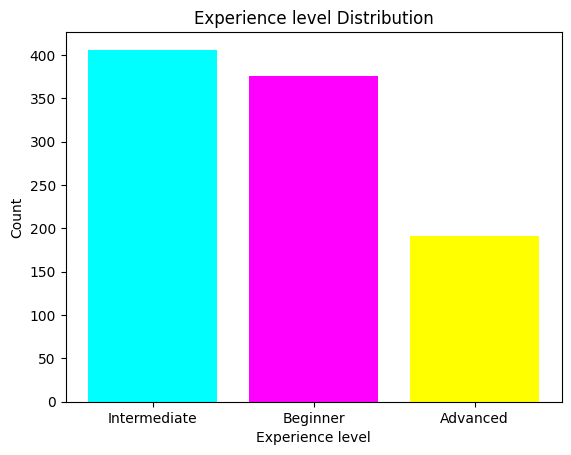

In [218]:
experience_level_map = {1: 'Beginner', 2: 'Intermediate', 3: 'Advanced'}
experience_level_counts = gym_data['Experience_Level'].map(experience_level_map).value_counts()
print(experience_level_counts)
plt.bar(experience_level_counts.index, experience_level_counts.values, color=['cyan', 'magenta', 'yellow'])
plt.xlabel('Experience level')
plt.ylabel('Count')
plt.title('Experience level Distribution')
plt.show()

Láthatjuk, hogy tényleg 1-től 3-ig tartó skálán mozog ez az adattag és nem kiegyensúlyozott adatokról van szó. Többségben vannak a haladó és kezdő szinten a terembe járók, mint a szakértői szinten.

#### *2.2.4 Adatok típusainak vizsgálata*

In [219]:
gym_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

A fenti információkból kivehetjük, hogy két object típusunk van, ami igazából szövegnek megfeleltethető a többi pedig egész és lebegőpontos számok. Ezek nagyrésze jó is nekünk, mert regresszió elemzéshez magas mérési szintű változók kellenek. A két object típusút átalakítjuk számmá, hogy regresszió alkalmazásnál könnyebben tudjunk vele dolgozni.

Oszlopok beosztása skálatípusok alapján:<br>
- Age: Arányskálázott
- Gender: Nominális
- Weight (kg): Arányskálázott
- Height (m): Arányskálázott
- Max_BPM: Arányskálázott
- Avg_BPM: Arányskálázott
- Resting_BPM: Arányskálázott
- Session_Duration (hours): Arányskálázott
- Calories_Burned: Arányskálázott
- Workout_Type: Nominális
- Fat_Percentage: Arányskálázott
- Water_Intake (liters): Arányskálázott
- Workout_Frequency (days/week): Arányskálázott
- Experience_Level: Ordinális
- BMI: Arányskálázott

#### *2.2.5 Adatok transzformálása*

In [220]:
onehot_encoder = OneHotEncoder()
genders = onehot_encoder.fit_transform(gym_data['Gender'].values.reshape(-1, 1)).toarray() # reshape első paramétere azt határozza meg, hogy automatikusan döntse el a dimenziót a tömb mérete alapján a második pedig, hogy egy oszlopos formátumra csinálja
workout_types = onehot_encoder.fit_transform(gym_data['Workout_Type'].values.reshape(-1, 1)).toarray()

gender_onehot = pd.DataFrame(genders, columns = ['Gender_Female', 'Gender_Male'])
workout_type_one_hot = pd.DataFrame(workout_types, columns = ['Workout_Type_Cardio', 'Workout_Type_HIIT', 'Workout_Type_Strength', 'Workout_Type_Yoga'])

gym_data = pd.concat([gym_data, gender_onehot], axis=1)
gym_data= gym_data.drop(['Gender'], axis=1)
gym_data = pd.concat([gym_data, workout_type_one_hot], axis=1)
gym_data= gym_data.drop(['Workout_Type'], axis=1)

gym_data.loc[:, 'Fat_Percentage'] = gym_data['Fat_Percentage'] / 100
gym_data.head()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Gender_Female,Gender_Male,Workout_Type_Cardio,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga
0,56,88.3,1.71,180,157,60,1.69,1313.0,0.126,3.5,4,3,30.20,0.0,1.0,0.0,0.0,0.0,1.0
1,46,74.9,1.53,179,151,66,1.30,883.0,0.339,2.1,4,2,32.00,1.0,0.0,0.0,1.0,0.0,0.0
2,32,68.1,1.66,167,122,54,1.11,677.0,0.334,2.3,4,2,24.71,1.0,0.0,1.0,0.0,0.0,0.0
3,25,53.2,1.70,190,164,56,0.59,532.0,0.288,2.1,3,1,18.41,0.0,1.0,0.0,0.0,1.0,0.0
4,38,46.1,1.79,188,158,68,0.64,556.0,0.292,2.8,3,1,14.39,0.0,1.0,0.0,0.0,1.0,0.0


Ezzel így átalakítottam a Gender, Workout_Type és a Fat_Percentage oszlopokat. Gender oszlopot one hot enkódolással alakítottuk ki. A zsír százalékot inkább leszűkítettem 0 és 1 intervallum közé, hogy a modell majd jobban tudjon ezzel az értékkel dolgozni. A Workout_Type oszlopot one hot enkódolással alakítottam ki.

# *3. Regresszió analízis és azok feltétel vizsgálatainak elvégzése és ellenőrzése*

## *3.1 Egyváltozós lineáris regresszió elemzés*

In [221]:
gym_data_numeric = gym_data.loc[:, ['Session_Duration (hours)', 'Calories_Burned']]
session_duration = gym_data_numeric['Session_Duration (hours)']
calories_burned = gym_data_numeric['Calories_Burned']
gym_data_numeric.describe()

,Session_Duration (hours),Calories_Burned
count,973.000000,973.000000
mean,1.256423,905.422405
std,0.343033,272.641516
min,0.500000,303.000000
25%,1.040000,720.000000
50%,1.260000,893.000000
75%,1.460000,1076.000000
max,2.000000,1783.000000


### *3.1.1 Adatok vizualizálása:*

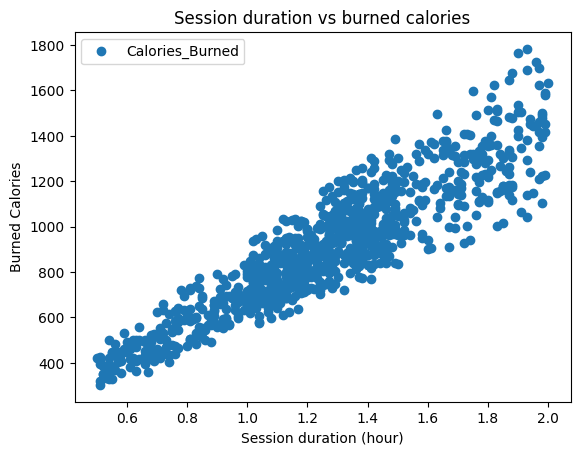

In [222]:
gym_data_numeric.plot(x='Session_Duration (hours)', y='Calories_Burned', style='o')
plt.title('Session duration vs burned calories')
plt.xlabel('Session duration (hour)')
plt.ylabel('Burned Calories')
plt.show()

### *3.1.2 Függő és független változók, tréning és teszt halmazok kialakítása*

In [223]:
# Függő és független változók:
X = gym_data_numeric.iloc[:, :-1].values # független (edzés időtartama)
y = gym_data_numeric.iloc[:, 1].values # függő (elégetett kalória)

# Test és training adatok létrehozása
# Én itt most a 70/30 arányt használom a tanulási/teszt felosztásban
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### *3.1.3 Modell példányosítása és tanítása*

In [224]:
# Modell létrehozása és illesztése
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

### *3.1.4 Illesztett modell paraméterei*

In [225]:
print('b0 értéke:', regressor.intercept_)
print('b1 értéke:', regressor.coef_)

b0 értéke: 9.630844307979373
b1 értéke: [712.9830103]


Adatok értelmezése: Minden edzéssel eltöltött óra ~713 kalória elégetésével jár

### *3.1.5 Előrejelzés a modell alapján*

In [226]:
# Előrejelzés a teszt halmazon
y_pred = regressor.predict(X_test)

ds_prediction = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
ds_prediction

,Actual,Predicted
0,999.0,1200.312472
1,854.0,993.547399
2,757.0,736.873515
3,585.0,587.147083
4,1364.0,1129.014170
...,...,...
287,950.0,922.249097
288,1396.0,1421.337205
289,1048.0,1079.105360
290,992.0,1071.975530


Láthatjuk, hogy a modell nagyjából jól jósolja meg az aktuális értéket, de vannak ahol eléggé fölé/alá lő az értéknek. Ezen tudnánk javítani, hogyha kivennénk az outlier értékeket az elégetett kalória oszlopból

### *3.1.6 Modell kirajzolása*

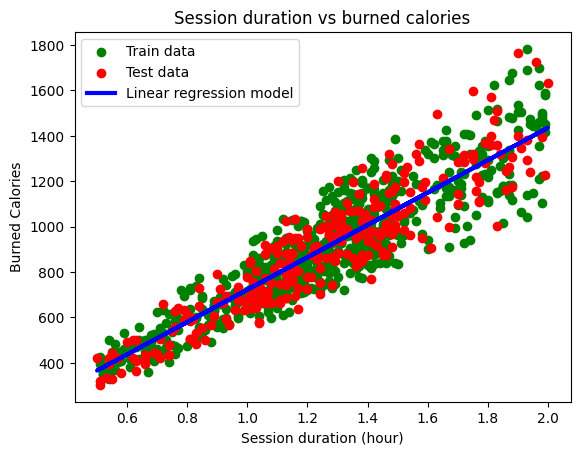

In [227]:
plt.scatter(X_train, y_train,  color='green', label='Train data')
plt.scatter(X_test, y_test,  color='red', label='Test data')
plt.plot(X, regressor.predict(X), color='blue', linewidth=3, label='Linear regression model')

plt.legend()

plt.title('Session duration vs burned calories')
plt.xlabel('Session duration (hour)')
plt.ylabel('Burned Calories')

plt.show()

### *3.1.7 Az illesztett modell hibája*

In [228]:
MAE = metrics.mean_absolute_error(y_test, y_pred) # Átlagos abszolút eltérés
MSE = metrics.mean_squared_error(y_test, y_pred) # Átlagos négyzetes eltérés
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred)) # Átlagos négyzetes eltérés gyöke
MAPE = metrics.mean_absolute_percentage_error(y_test, y_pred)*100 # Átlagos hiba százalék
r2 = metrics.r2_score(y_test, y_pred)*100 # R^2 kiszámítása

print('Mean Absolute Error: {:.4f}'.format(MAE))
print('Mean Squared Error: {:.4f}'.format(MSE))
print('Root Mean Squared Error: {:.4f}'.format(RMSE))
print('Mean Absolute Percentage Error: {:.4f}%'.format(MAPE))
print('R^2 value: {:.4f}%'.format(r2))

Mean Absolute Error: 87.3456
Mean Squared Error: 12167.2529
Root Mean Squared Error: 110.3053
Mean Absolute Percentage Error: 10.0591%
R^2 value: 84.6132%


Az első az átlagos abszolút eltérést (MAE) adja meg az eredeti adattól, ami jelen esetben ~87.3, tehát átlagosan 87.3 egységgel tér el a modell által kiadott jóslás, mint a valódi érték. Hogyha ennek az értéke alacsonyabb, akkor tudjuk növelni a modell pontosságát. A második az átlagos négyzetes eltérést (MSE) adja meg az eredeti adattól, ami jelen esetben ~12167.2, ez az érték eléggé magas, de az outlierek kihatással vannak erre az értékre. A harmadik az átlagos négyzetes eltérés gyöke (RMSE), ami most ~110.3, ezzel az értékkel könnyebben tudunk dolgozni, mint az átlagos négyzetes eltéréssel (MSE). Azt adja meg, hogy ennyi egységgel eltér a valós adattól a jóslás átlagban. A negyedik érték az átlagos hiba százalék (MAPE), ami most ~10%. Ez a modell által adott jóslásnak a hibája átlagban. Itt még kiirattam az R^2 értékét, ami a modell pontosságát határozza meg. Ebben az esetben ez 84,6%, ami kifejezetten jó értéknek mondható

### *3.1.8 Modell finomhangolása és újraértékelése*

In [229]:
box = plt.boxplot(calories_burned)
plt.close()
upper_whisker = box['whiskers'][1].get_ydata()[1]
print(f'Upper whisker value: {upper_whisker}')

modified_gym_data = gym_data_numeric.copy(True)
modified_gym_data.loc[modified_gym_data['Calories_Burned'] > upper_whisker] = np.nan
modified_gym_data.dropna(axis=0, how='any', inplace=True)
modified_gym_data.shape

Upper whisker value: 1598.0


(963, 2)

Kiszedtem a boxplotból a felső whisker értékét és ami érték ez felett volt, azt kiszedtem egy új változóba. 10-el kevesebb sor lett így.

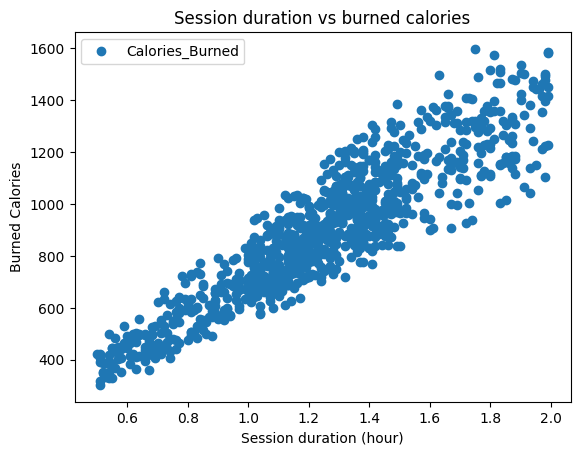

In [230]:
modified_gym_data.plot(x='Session_Duration (hours)', y='Calories_Burned', style='o')
plt.title('Session duration vs burned calories')
plt.xlabel('Session duration (hour)')
plt.ylabel('Burned Calories')
plt.show()

In [231]:
# Függő és független változók:
X_m = modified_gym_data.iloc[:, :-1].values
y_m = modified_gym_data.iloc[:, 1].values

# Test és training adatok létrehozása
# Én itt most a 70/30 arányt használom a tanulási/teszt felosztásban
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.3, random_state=0)

# Modell létrehozása és illesztése
regressor.fit(X_train_m, y_train_m)

print ('b0 értéke:', regressor.intercept_)
print ('b1 értéke:', regressor.coef_)

# Előrejelzés a teszt halmazon
y_pred_m = regressor.predict(X_test_m)

ds_prediction = pd.DataFrame({'Actual': y_test_m, 'Predicted': y_pred_m})
ds_prediction

b0 értéke: 21.075088918801043
b1 értéke: [699.08016211]


,Actual,Predicted
0,1082.0,1062.704530
1,1053.0,964.833308
2,1195.0,964.833308
3,802.0,811.035672
4,1096.0,1209.511365
...,...,...
284,950.0,915.897696
285,757.0,734.136854
286,1048.0,1069.695332
287,1181.0,1314.373389


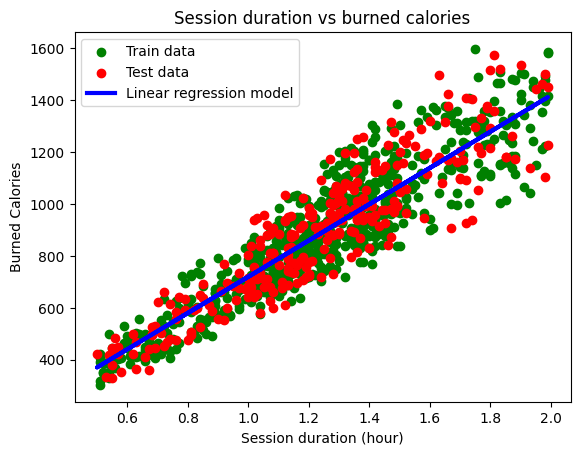

In [232]:
# Plot outputs
plt.scatter(X_train_m, y_train_m,  color='green', label='Train data')
plt.scatter(X_test_m, y_test_m,  color='red', label='Test data')
plt.plot(X_m, regressor.predict(X_m), color='blue', linewidth=3, label='Linear regression model')

plt.legend()

plt.title('Session duration vs burned calories')
plt.xlabel('Session duration (hour)')
plt.ylabel('Burned Calories')

plt.show()

In [233]:
MAE = metrics.mean_absolute_error(y_test_m, y_pred_m)
MSE = metrics.mean_squared_error(y_test_m, y_pred_m)
RMSE = np.sqrt(metrics.mean_squared_error(y_test_m, y_pred_m))
MAPE = metrics.mean_absolute_percentage_error(y_test_m, y_pred_m)*100
r2 = metrics.r2_score(y_test_m, y_pred_m)*100 # R^2 kiszámítása

print('Mean Absolute Error: {:.4f}'.format(MAE))
print('Mean Squared Error: {:.4f}'.format(MSE))
print('Root Mean Squared Error: {:.4f}'.format(RMSE))
print('Mean Absolute Percentage Error: {:.4f}%'.format(MAPE))
print('R^2 value: {:.4f}%'.format(r2))

Mean Absolute Error: 89.6945
Mean Squared Error: 12771.3168
Root Mean Squared Error: 113.0103
Mean Absolute Percentage Error: 10.1371%
R^2 value: 82.2037%


Miután kiszedtem a boxplotból látott outlier értékeket és a módosított adathalmazon láthatjuk, hogy csökkentett adatokon a model az edzéssel eltöltött idő alatt 712-ről 700-ra csökkent és a modell hiba mértéke is nőtt egy kicsivel. Tehát az outlier kívételével nem nőtt a modell teljesítménye, hanem rontott rajta. Az adathalmazban szereplő outlier értékek azért annyira nem esnek durván kívül a többi adattól, hanem csak ritkább az esetük. Ebben az esetben más után kell nézni, hogy mivel lehetne javítani a modell teljesítményén. Láthatjuk, hogy 84,6%-ról 82,2%-ra csökkent a modell pontossága.

### *3.1.9 Lineáris regresszió feltételeinek ellenőrzése*

#### *3.1.9.1 Korrelációs teszt lefuttatása a független (Edzőteremben eltöltött idő {óra}) és a függő (Elégetett kalória) változó között.*

Mivel mindkettő arányskálázott így mehet a Pearson féle korreláció

PearsonRResult(statistic=np.float64(0.9081403755270122), pvalue=np.float64(0.0))


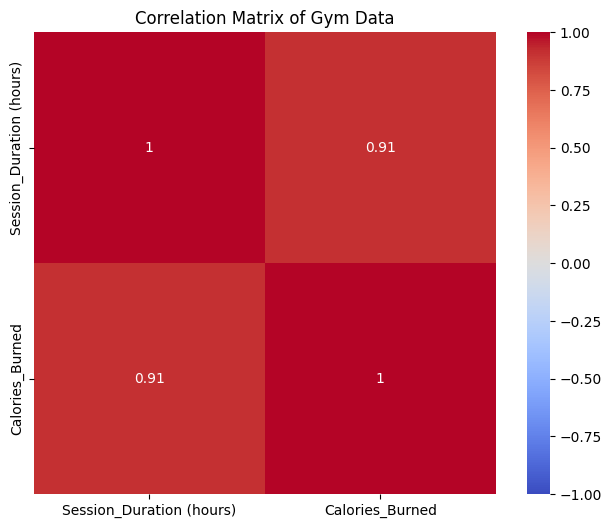

In [234]:
print(stats.pearsonr(session_duration, calories_burned))

corr_matrix = gym_data_numeric.corr(method = 'pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square = True)
plt.title("Correlation Matrix of Gym Data")
plt.show()

Az ábrán láthatjuk, hogy az edzőteremben eltöltött idő és az elégetett kalória között nagyon erős kapcsolat van és szignifikancia szintje 0,05 alatt van, tehát elutasítjuk a nullhipotézist, amiből következik, hogy a két változó között van kapcsolat

Változók normális eloszlásának ellenőrzése

<Axes: xlabel='Session_Duration (hours)', ylabel='Count'>

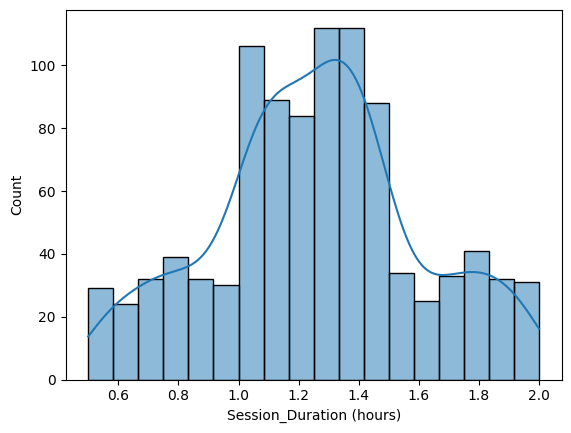

In [235]:
sns.histplot(session_duration, kde = True)

<Axes: xlabel='Calories_Burned', ylabel='Count'>

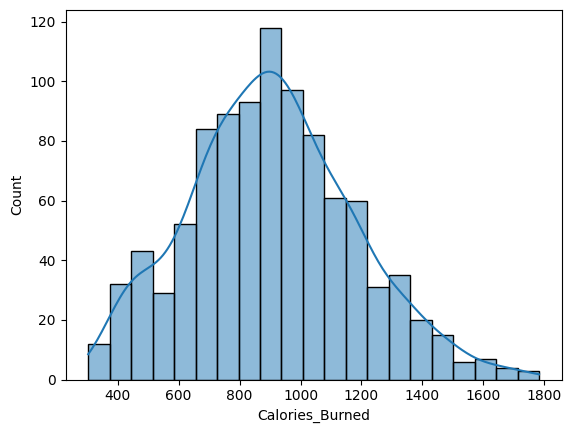

In [236]:
sns.histplot(calories_burned, kde = True)

Az ábrákból láthatjuk, hogy a változók nem normális eloszlásúak, ezért a Pearson-féle korrelációs eljárás helyett inkább érdemes másikat használni, mint a Spearman korrelációt

SignificanceResult(statistic=np.float64(0.9034784709494305), pvalue=np.float64(0.0))


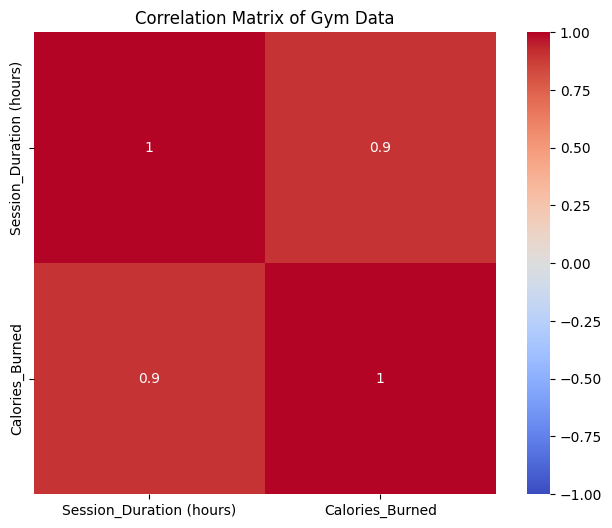

In [237]:
print(stats.spearmanr(session_duration, calories_burned))

corr_matrix = gym_data_numeric.corr(method = 'spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square = True)
plt.title("Correlation Matrix of Gym Data")
plt.show()

Láthatjuk, hogy nem sokat változott az erőssége és a p-value értéke. De ha már itt vagyunk nézzük meg Kendall-féle eljárásra is

SignificanceResult(statistic=np.float64(0.7369800606105592), pvalue=np.float64(4.390934300484667e-257))


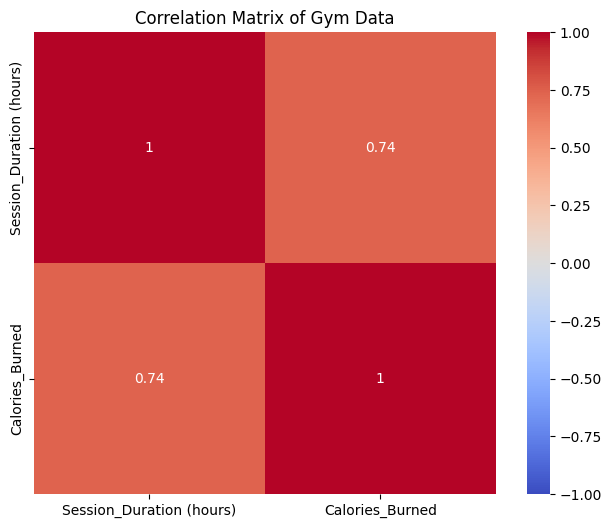

In [238]:
print(stats.kendalltau(session_duration, calories_burned))

corr_matrix = gym_data_numeric.corr(method = 'kendall')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square = True)
plt.title("Correlation Matrix of Gym Data")
plt.show()

Láthatjuk, hogy a Kendall féle korreláció számításnál azért alacsonyabb értéke kapunk a korrelációra, mint az előzőeknél, de itt is kiolvasható egy közepes kapcsolat a két változó között. Mivel a p-value értéke ~4.4*10^-257 ez egy nagyon alacsony értéke és bőven a szignifikancia szint alatt, elvetjük a nullhipotizést és kijelenthetjük, hogy a két változó között van lineáris kapcsolat

#### 3.1.9.2 *Hibatagok normális eloszlásának ellenőrzése*

ShapiroResult(statistic=np.float64(0.9856319532830449), pvalue=np.float64(0.00513532556276515))


<Axes: ylabel='Count'>

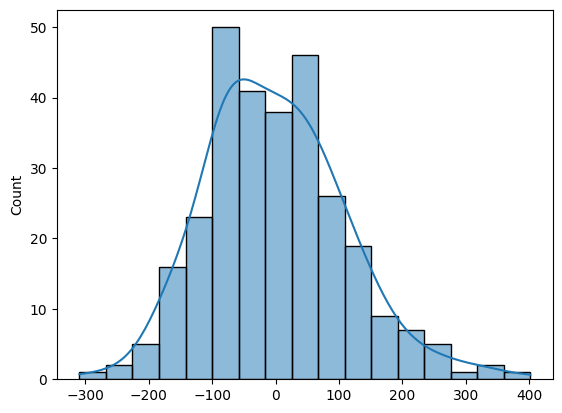

In [239]:
residuals = y_test - y_pred
print(stats.shapiro(residuals))

sns.histplot(residuals, kde = True)

Lefuttattam a shapiro tesztet, aminek a p-value értéke 0.005, ami a szignifikancia szint (0,05) alatt van, tehát nem normális eloszlású az adat, de ezt az ábráról is letudjuk olvasni

Nézzünk meg egy másik módszert is a normális eloszlás ellenőrzésére. Ehhez pedig a Kolmogorow-Smirnov tesztet nézzük meg

In [240]:
ks_stat, ks_p_value = stats.kstest(residuals, 'norm')

print("Kolmogorov-Smirnov Test Statistic:", ks_stat)
print("Kolmogorov-Smirnov p-value:", ks_p_value)

Kolmogorov-Smirnov Test Statistic: 0.5100990016924708
Kolmogorov-Smirnov p-value: 5.4668457283057445e-71


Mivel a Kolmogorov-Smirnov teszt p-value értéke 0.05 szignifikancia szint alatt van, ezért ebből is láthatjuk, hogy nem normális eloszlású a hibatag

#### 3.1.9.3 *Hibatagok autokorrelációjának ellenőrzése*

In [241]:
dw_stat = durbin_watson(residuals)

print("Durbin-Watson statistic:", dw_stat)

Durbin-Watson statistic: 2.00470789161579


Hogyha a Durbin-Watson teszt értéke 2, akkor azt jelenti, hogy nincs autokorreláció, hogyha nagyobb, mint 2 akkor negatív az autokorreláció hogyha pedig kisebb mint 2 akkor pozitív az autokorreláció. Mivel a mi értékünk nagyon közel van kettőhöz így kijelenthetjük, hogy nincs autokorreláció.

#### *3.1.9.4 Hibatagok heteroszkedaszticitásának ellenőrzése*

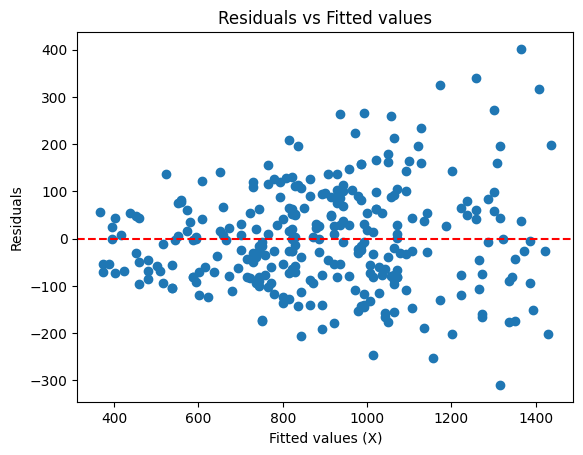

In [242]:
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values (X)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.show()

Mivel kúp alakban távolódnak az értékek nullától az x tengelyen, ezért heteroszkedaszticitásról beszélünk.

Nézzünk meg egy másik módot, amivel tudjuk ellenőrizni a heteroszkedaszticitást. Például a Breusch-Pagan ellenőrzést

In [243]:
exog = sm.add_constant(y_pred)
bp_test = het_breuschpagan(residuals, exog)

bp_test_statistic, bp_test_p_value = bp_test[0], bp_test[1]

print("Breusch-Pagan Test Statistic:", bp_test_statistic)
print("Breusch-Pagan p-value:", bp_test_p_value)

Breusch-Pagan Test Statistic: 34.30902385657634
Breusch-Pagan p-value: 4.7019654153233896e-09


Mivel a p-value, ami kijött az bőven 0.05 szignifikancia szint alatt van így kijelenthetjük, hogy heteroszkedaszticitásról beszélünk.

### 3.1.10 *Összegzés*

- Heteroszkedaszticitás van
- Nincs autokorreláció
- Normális eloszlás nem teljesül
- Függő és független változat között lineáris kapcsolat van

Ezekből láthatjuk, hogy nem teljesülnek a módszer alkalmazásának feltételei, mert nem szabadna heteroszkedaszticitásnak lennie és normális eloszlásúnak kéne lennie a hibatagnak

## *3.2 Többváltozós lineáris regresszió*

In [244]:
gym_data.describe()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Gender_Female,Gender_Male,Workout_Type_Cardio,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga
count,973.000000,973.000000,973.00000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,38.683453,73.854676,1.72258,179.883864,143.766701,62.223022,1.256423,905.422405,0.249768,2.626619,3.321686,1.809866,24.912127,0.474820,0.525180,0.262076,0.227133,0.265159,0.245632
std,12.180928,21.207500,0.12772,11.525686,14.345101,7.327060,0.343033,272.641516,0.062594,0.600172,0.913047,0.739693,6.660879,0.499622,0.499622,0.439990,0.419194,0.441645,0.430683
min,18.000000,40.000000,1.50000,160.000000,120.000000,50.000000,0.500000,303.000000,0.100000,1.500000,2.000000,1.000000,12.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,58.100000,1.62000,170.000000,131.000000,56.000000,1.040000,720.000000,0.213000,2.200000,3.000000,1.000000,20.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,70.000000,1.71000,180.000000,143.000000,62.000000,1.260000,893.000000,0.262000,2.600000,3.000000,2.000000,24.160000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,49.000000,86.000000,1.80000,190.000000,156.000000,68.000000,1.460000,1076.000000,0.293000,3.100000,4.000000,2.000000,28.560000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,59.000000,129.900000,2.00000,199.000000,169.000000,74.000000,2.000000,1783.000000,0.350000,3.700000,5.000000,3.000000,49.840000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### *3.2.1 Független változók kiválasztása*

Most csak a magas mérési szintű változókat teszem bele a modellbe

In [245]:
# Függő és független változók:
X = gym_data[['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Fat_Percentage', 'Water_Intake (liters)', 'BMI']]
y = gym_data['Calories_Burned']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Calories_Burned   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     3332.
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:27:41   Log-Likelihood:                -5098.5
No. Observations:                 973   AIC:                         1.022e+04
Df Residuals:                     962   BIC:                         1.027e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

A Max_BPM oszlop szignifikancia szintje nem 0.05 alatt van, ezért őt kivesszük a modellből.

In [246]:
X = gym_data[['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Fat_Percentage', 'Water_Intake (liters)', 'BMI']]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Calories_Burned   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     3706.
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:27:41   Log-Likelihood:                -5098.5
No. Observations:                 973   AIC:                         1.022e+04
Df Residuals:                     963   BIC:                         1.027e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Így most már mindegyik független változó a szignifikancia szint alatt van. Az algoritmus megjegyzi, hogy erős multikollinearitás, ezért nézzük rá ennek az értékére jobban.

### *3.2.3 Multikollinaritás vizsgálata*

In [247]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                    feature          VIF
0                     const  4109.129236
1                       Age     1.014264
2               Weight (kg)    71.416234
3                Height (m)    20.580002
4                   Avg_BPM     1.006552
5               Resting_BPM     1.007384
6  Session_Duration (hours)     1.599757
7            Fat_Percentage     2.177971
8     Water_Intake (liters)     1.849493
9                       BMI    64.030025


Láthatjuk, hogy vannak független változók, amik között túl szoros a korrelációs kapcsolat ezért el kell távolítanunk változókat, hogy ezt megszüntessük. De ehhez nézzük meg a korrelációs mátrixot, ami segítségünkre lehet ennek meghatározásában

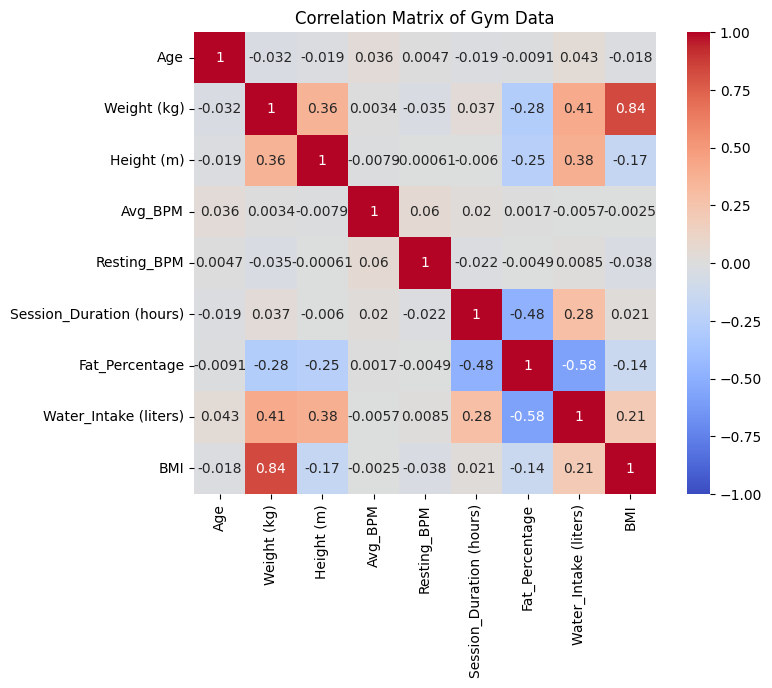

In [248]:
corr_matrix = gym_data[['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Fat_Percentage', 'Water_Intake (liters)', 'BMI']].corr(method = 'spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square = True)
plt.title("Correlation Matrix of Gym Data")
plt.show()

A korrelációs mátrixon láthatjuk, hogy a súly és a BMI között erős korrelációs kapcsolat van. A modellből kiszedem a BMI értékét, mert szerintem a modellhez ő annyit nem fog tudni hozzátenni, mint a súly.

In [249]:
X = gym_data[['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Fat_Percentage', 'Water_Intake (liters)']]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Calories_Burned   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     4058.
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:27:41   Log-Likelihood:                -5111.7
No. Observations:                 973   AIC:                         1.024e+04
Df Residuals:                     964   BIC:                         1.029e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [250]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                    feature         VIF
0                     const  546.573092
1                       Age    1.009884
2               Weight (kg)    1.289267
3                Height (m)    1.286005
4                   Avg_BPM    1.005877
5               Resting_BPM    1.007051
6  Session_Duration (hours)    1.597156
7            Fat_Percentage    2.173700
8     Water_Intake (liters)    1.837331


Most már a VIF értékek számottevően jobbak viszont a model még mindig azt írja, hogy erős multikollinearitás van, tehát nézzük meg a korrelációs mátrixot újra

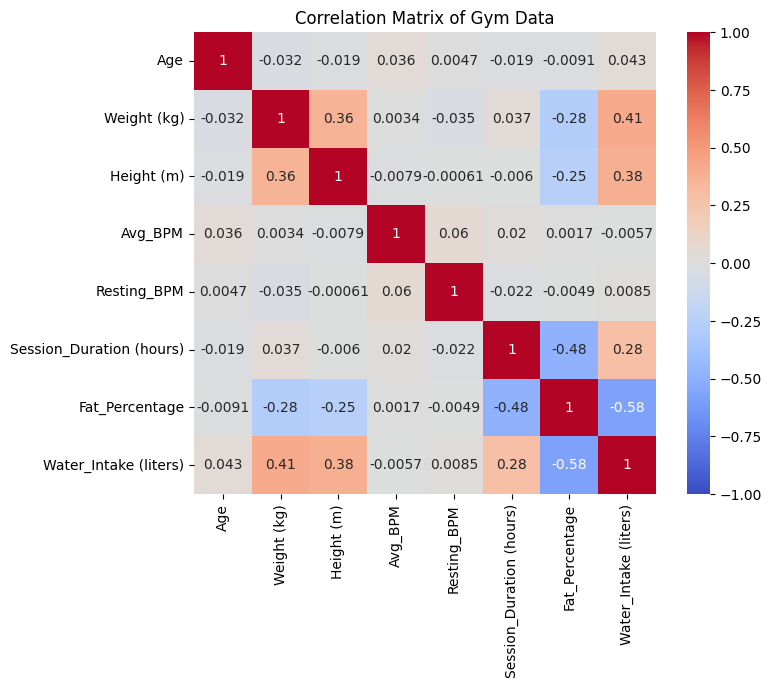

In [251]:
corr_matrix = gym_data[['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Fat_Percentage', 'Water_Intake (liters)']].corr(method = 'spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square = True)
plt.title("Correlation Matrix of Gym Data")
plt.show()

Én már nem vennék ki több változót a modellből. Többségében a korrelációs mátrixról azt olvashatjuk le, hogy nincsen kapcsolat több változó között, viszont láthatunk pár gyenge és közepes kapcsolatot a független változók között. Hogyha a modellt nézzük akkor azt állapíthatjuk meg, hogy minél idősebb valaki annál kevesebb lesz az elégetett kalória, de csak apró mértékben. Hogyha a súlyt és a nyugalmi pulzust nézzük akkor azok csekély méretben hatnak az elégetett kalóriára. A magasságot hogyha nézzük, minél magasabb valaki annál több lesz az elégetett kalória az edzés során. Minél nagyobb valakinek az átlagos pulzusa annál több lesz az elégetett kalória, de apró mértékben. Viszont hogyha az edzéssel eltöltött időt nézzük akkor azt látjuk, hogy minél több időt tölt az edzőteremben valaki annál több kalóriát fog égetni és itt nagy mértékről beszélünk. Hogyha megnézzük a zsírszázalékot akkor láthatjuk, hogy minél több valakinek a zsíszázaléka annál kevesebb lesz az elégetett kalóriája. A vízfogyasztásnál pedig láthatjuk, hogy minél több vizet fogyaszt valaki annál több kalóriát fog elégetni az edzés során. A modellből azt is megtudjuk állapítani, hogy a modell pontossága ~97% (Adj. R-squared), ami elképesztően jó

Miután kiválasztottuk, hogy mely független változókkal próbáljuk megmagyarázni függő változót akkor csináljunk test és training halmazokat és nézzük meg a hiba értékeket és hogy ténylegesen mennyire pontosan jósolja meg az értékeket

### *3.2.4 Függő és független változók, tréning és teszt halmazok kialakítása*

In [252]:
# Függő és független változók:
X = gym_data[['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Fat_Percentage', 'Water_Intake (liters)']]
y = gym_data['Calories_Burned']

# Test és training adatok létrehozása
# Én itt most a 70/30 arányt használom a tanulási/teszt felosztásban
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### *3.2.5 Modell tanítása*

In [253]:
# Modell illesztése
regressor.fit(X_train, y_train)

LinearRegression()

### *3.2.6 Illesztett modell paraméterei*

In [254]:
df_coeff = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
df_coeff

,Coefficient
Age,-3.355697
Weight (kg),0.743840
Height (m),95.385674
Avg_BPM,6.381041
Resting_BPM,0.413632
Session_Duration (hours),689.218109
Fat_Percentage,-123.751101
Water_Intake (liters),27.241167


Közel ugyan azokat a Coefficient értékeket kaptuk, mint az OSL regressziónál elemzésnél. Elemezzük ki az értékeket most számokkal. Hogyha idősebb valaki akkor 3.3 kalóriával kevesebbet éget el. Hogyha valaki elhízottabb akkor 0.7 kalóriával többet éget el. Hogyha valaki magasabb akkor 100 kalóriával többet éget el az edzés során. Hogyha valakinek az átlagos pulzusszáma magasabb akkor 6.3 kalóriával többet éget el. Hogyha valakinek a nyugalmi pulzusa nagyobb akkor 0.5 kalóriával éget többet el. Hogyha valaki több időt tölt el az edzőteremben akkor 683 kalóriával többet éget el. Hogyha valakinek nagyobb a testzsír százaléka akkor 150 kalóriával kevesebbet éget el. Hogyha valaki több vizet iszik az edzés során akkor 31 kalóriával többet éget el.

### *3.2.7 Előrejelzés a modell alapján*

In [255]:
y_pred = regressor.predict(X_test)

df_prediction_MLR = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_prediction_MLR

,Actual,Predicted
810,999.0,1087.468000
142,854.0,894.012250
524,757.0,733.867961
312,585.0,617.679132
968,1364.0,1316.652979
...,...,...
898,950.0,940.572466
440,1396.0,1436.457508
20,1048.0,1075.776220
880,992.0,937.792149


Ebből a pár adatból látni lehet, hogy jóval, de jóval pontosabban határozza meg az elégetett kalóriát, mint az egyváltozós lineáris regressziónál. Nincsenek annyira durva kiugró értékek.

### *3.2.8 Illesztett modell hibája*

In [256]:
MAE = metrics.mean_absolute_error(y_test, y_pred)
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
MAPE = metrics.mean_absolute_percentage_error(y_test, y_pred)*100

print('Mean Absolute Error: {:.4f}'.format(MAE))
print('Mean Squared Error: {:.4f}'.format(MSE))
print('Root Mean Squared Error: {:.4f}'.format(RMSE))
print('Mean Absolute Percentage Error: {:.4f}%'.format(MAPE))

Mean Absolute Error: 34.9767
Mean Squared Error: 2063.1759
Root Mean Squared Error: 45.4222
Mean Absolute Percentage Error: 4.4283%


Láthatjuk, hogy a az átlagos hiba 35.63, ami az átlagos elégetett kalóriának (905.42) a 3,9%-a. A hiba azért annyira nem vészes szóval eltudjuk fogadni. Ugyanez az RMSE-re vetítve 4,9%. Ezek az értékek sokkal jobbak, mint amit láthattunk egy egyváltozós regresszió analízisnél.

### *3.2.9 Lineáris regresszió feltételeinek ellenőrzése*

A multikollinearitást ellenőriztük korábban szóval nézzük rá a többire

#### *3.2.9.1 Korrelációs vizsgálat*

                   Variable       P-value
0                       Age  1.247822e-06
1               Weight (kg)  2.881149e-03
2                Height (m)  7.038380e-03
3                   Avg_BPM  1.064339e-27
4               Resting_BPM  6.068211e-01
5  Session_Duration (hours)  0.000000e+00
6            Fat_Percentage  2.952600e-95
7     Water_Intake (liters)  1.313806e-30


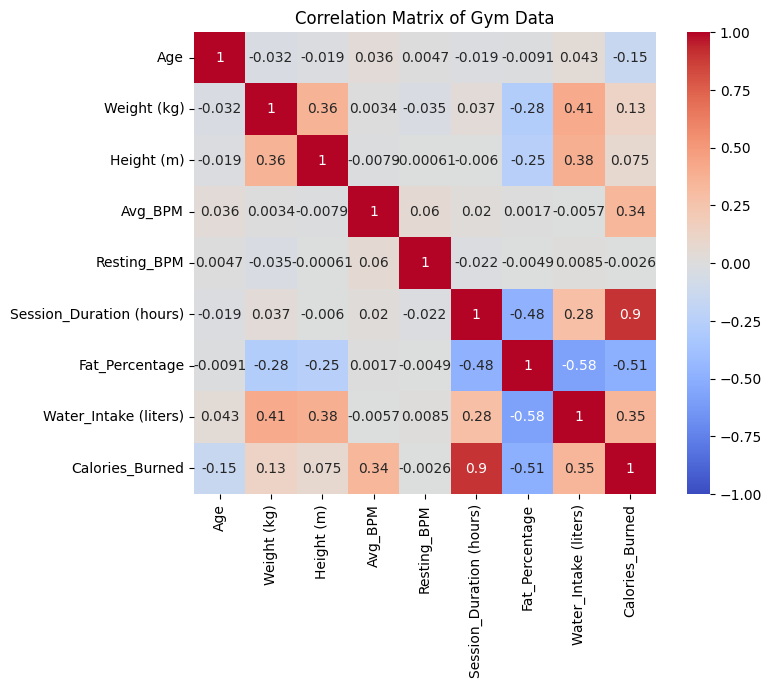

In [257]:
independent_vars = ['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 
                    'Resting_BPM', 'Session_Duration (hours)', 
                    'Fat_Percentage', 'Water_Intake (liters)']
dependent_var = 'Calories_Burned'
correlation_results = []

for var in independent_vars:
    corr, p_value = stats.pearsonr(gym_data[var], gym_data[dependent_var])
    correlation_results.append({
        'Variable': var,
        'P-value': p_value
    })

correlation_df = pd.DataFrame(correlation_results)
print(correlation_df)

corr_matrix = gym_data[['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Fat_Percentage', 'Water_Intake (liters)', 'Calories_Burned']].corr(method = 'spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square = True)
plt.title("Correlation Matrix of Gym Data")
plt.show()

A p-valuekból láthatjuk, hogy majdnem mindegyik változó 0.05 szignifikancia szint alatt van, kívéve a nyugalmi állapotú pulzusszám, ami azt jelenti, hogy nincs lineáris kapcsolat a két változó között. Tehát a modellből ezt a változót ki kellene szedni. És láthatjuk, hogy vannak olyan változók, amik a függő változóval erősebb kapcsolatban állnak és vannak olyanok, amik kevésbé.

#### *3.2.9.2 Hibatagok normális eloszlásának ellenőrzése*

ShapiroResult(statistic=np.float64(0.9875015452331474), pvalue=np.float64(0.012552485660951775))


<Axes: xlabel='Calories_Burned', ylabel='Count'>

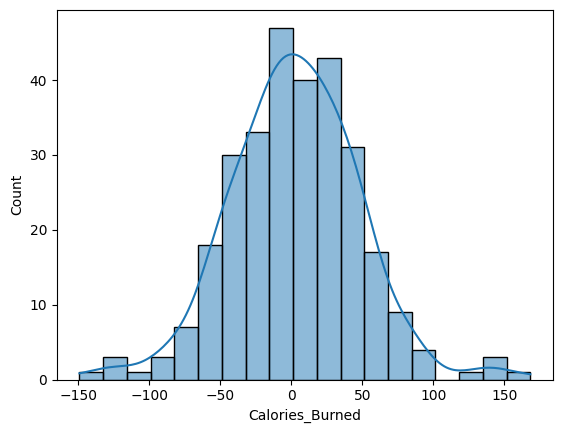

In [258]:
residuals = y_test - y_pred
print(stats.shapiro(residuals))

sns.histplot(residuals, kde = True)

Az egyváltozós lineáris regressziós hibatag normális eloszlásához képest ez most jóval jobban követi. A p-value értéke, mivel 0.05 szignifikancia szint felett van ezért kijelenthetjük, hogy normális eloszlásúak a hibatagok

Nézzünk itt is meg egy másik módszerrel is ezt. Ehhez pedig a Kolmogorow-Smirnov tesztet nézzük meg

In [259]:
ks_stat, ks_p_value = stats.kstest(residuals, 'norm')

print("Kolmogorov-Smirnov Test Statistic:", ks_stat)
print("Kolmogorov-Smirnov p-value:", ks_p_value)

Kolmogorov-Smirnov Test Statistic: 0.4984918122242178
Kolmogorov-Smirnov p-value: 1.3610444908847391e-67


Ezzel a teszttel pedig azt kaptuk, hogy nem normális eloszlásúak a hibatagok. De itt most a Shapiro-Wilk tesztnek jobban hiszek, mert megbízhatóbb közepes adathalmazoknál. Shapiro-Wilk tesztnél is kijöhet ennél nagyobb adathalmaznál, hogy érzékenyebb lesz és hibás döntést hoz.

#### *3.2.9.3 Hibatagok autokorrelációjának ellenőrzése*

In [260]:
dw_stat = durbin_watson(residuals)

print("Durbin-Watson statistic:", dw_stat)

Durbin-Watson statistic: 1.9203524156537588


Ebben az esetben már autokorrelációról meglétéről beszélünk, mert 2-es érték alatt van, ami azt jelenti, hogy pozitív az autokorreláció

#### *3.2.9.4 Hibatagok heteroszkedaszticitásának ellenőrzése*

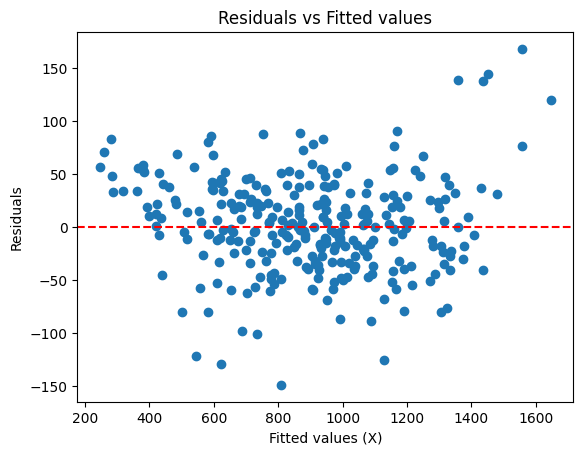

In [261]:
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values (X)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.show()

Az ábráról most nehezebb leolvasni a heteroszkedaszticitást, de még mindig arról beszlénük. Viszont kezd hasonlítani a homoszkedasztikushoz.

Nézzünk meg egy másik módot, amivel tudjuk ellenőrizni a heteroszkedaszticitást. Például a Breusch-Pagan ellenőrzést

In [262]:
exog = sm.add_constant(y_pred)
bp_test = het_breuschpagan(residuals, exog)

bp_test_statistic, bp_test_p_value = bp_test[0], bp_test[1]

print("Breusch-Pagan Test Statistic:", bp_test_statistic)
print("Breusch-Pagan p-value:", bp_test_p_value)

Breusch-Pagan Test Statistic: 5.168956048707618
Breusch-Pagan p-value: 0.02299403022419997


A Breusch-Pagan módszernél pedig láthatjuk, hogy a heteroszkedaszticitás teljesül rá, mert 0.05 szignifikancia szint alatt van.

#### *3.2.9.5 Összegzés*

- Modellből ki kell venni változókat, hogy teljesüljön a független és függő változók közötti lineáris összefüggés
- A hibatagok normális eloszlásúnak jöttek ki a Shapiro-Wilk teszttel, viszont a Kolmogorov-Smirnov teszttel már nem ez az érték jött ki
- Van autokorreláció
- Van heteroszkedaszticitás
- VIF értékek szerint nem beszélünk multikollinearitásról, viszont az OLS Regressziós algoritmus azt mondja, hogy magas a multikollinearitás értéke még a modellben

Ezekből láthatjuk, hogy nem teljesülnek a módszer alkalmazásának feltételei, mert nem szabadna heteroszkedaszticitásnak lennie, nem szabadna autokorrelációnak lennie.

In [263]:
X = gym_data[['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Fat_Percentage', 'Water_Intake (liters)', 'BMI']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
regressor.fit(X_train, y_train)
df_coeff = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
df_prediction_MLR = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
r2 = metrics.r2_score(y_test, y_pred)*100

# **4 Regularizációs technikákkal elemzés a modell változásában**

## *4.1 Lasso regresszió*

Büntetést ad a veszteségfüggvényhez az együtthatók négyzeteinek összegével arányosan. Nagyon jól működik, hogyha a független változók között multikollinearitás áll fent. Hasznos, hogyha az összes független változótól várjuk, hogy részt vegyen a magyarázó változó értékelésében

In [264]:
# új modell létrehozása és illesztése
regressor_Lasso = Lasso(alpha=0.1)
regressor_Lasso.fit(X_train, y_train)

# együtthatók mentése:
df_coeff['Coefficient_Lasso'] = regressor_Lasso.coef_

# Előrejelzés a teszt halmazon
y_pred_Lasso = regressor_Lasso.predict(X_test)

# Az előrejelzés adatainak kimentése DataFrame-be későbbi felhasználás céljából
df_prediction_MLR['Predicted_Lasso'] = y_pred_Lasso

# Az illesztés hibájának számítása
MAE_Lasso = metrics.mean_absolute_error(y_test, y_pred_Lasso)
MSE_Lasso = metrics.mean_squared_error(y_test, y_pred_Lasso)
RMSE_Lasso = np.sqrt(metrics.mean_squared_error(y_test, y_pred_Lasso))
MAPE_Lasso = metrics.mean_absolute_percentage_error(y_test, y_pred_Lasso)
r2_Lasso = metrics.r2_score(y_test, y_pred_Lasso)*100

print('Mean Absolute Error: {:.4f}'.format(MAE_Lasso))
print('Mean Squared Error: {:.4f}'.format(MSE_Lasso))
print('Root Mean Squared Error: {:.4f}'.format(RMSE_Lasso))
print('Mean Absolute Percentage Error: {:.4f}%'.format(MAPE_Lasso))
print('R^2 value: {:.4f}%'.format(r2_Lasso))

Mean Absolute Error: 34.7132
Mean Squared Error: 2038.6455
Root Mean Squared Error: 45.1514
Mean Absolute Percentage Error: 0.0440%
R^2 value: 97.4219%


## *4.2 Ridge regresszió*

Büntetést ad a veszteségfüggvényhez az együtthatók aboszlút értékeivel arányosan. Ideális, hogyha a modellben sok irreveláns független változó van és ezeket ő kitudja szűrni.

In [265]:
# új modell létrehozása és illesztése
regressor_Ridge = Ridge(alpha=0.1)
regressor_Ridge.fit(X_train, y_train)

# együtthatók mentése:
df_coeff['Coefficient_Ridge'] = regressor_Ridge.coef_

# Előrejelzés a teszt halmazon
y_pred_Ridge = regressor_Ridge.predict(X_test)

# Az előrejelzés adatainak kimentése DataFrame-be későbbi felhasználás céljából
df_prediction_MLR['Predicted_Ridge'] = y_pred_Ridge

# Az illesztés hibájának számítása
MAE_Ridge = metrics.mean_absolute_error(y_test, y_pred_Ridge)
MSE_Ridge = metrics.mean_squared_error(y_test, y_pred_Ridge)
RMSE_Ridge = np.sqrt(metrics.mean_squared_error(y_test, y_pred_Ridge))
MAPE_Ridge = metrics.mean_absolute_percentage_error(y_test, y_pred_Ridge)
r2_Ridge = metrics.r2_score(y_test, y_pred_Ridge)*100

print('Mean Absolute Error: {:.4f}'.format(MAE_Ridge))
print('Mean Squared Error: {:.4f}'.format(MSE_Ridge))
print('Root Mean Squared Error: {:.4f}'.format(RMSE_Ridge))
print('Mean Absolute Percentage Error: {:.4f}%'.format(MAPE_Ridge))
print('R^2 value: {:.4f}%'.format(r2_Ridge))

Mean Absolute Error: 34.4908
Mean Squared Error: 2008.9676
Root Mean Squared Error: 44.8215
Mean Absolute Percentage Error: 0.0436%
R^2 value: 97.4595%


## *4.3 Elastic Net*

Kombinálja a Ridge és Lasso által adott büntetést a veszteségfüggvényhez. Tud jellemző kiválasztást csinálni, miközben robosztusságot tart fenn a multikollinearitás szempontjából.

In [266]:
# új modell létrehozása és illesztése
regressor_ElasticNet = ElasticNet(alpha=0.1, l1_ratio=0.5)
regressor_ElasticNet.fit(X_train, y_train)

# együtthatók mentése:
df_coeff['Coefficient_ElasticNet'] = regressor_ElasticNet.coef_

# Előrejelzés a teszt halmazon
y_pred_ElasticNet = regressor_ElasticNet.predict(X_test)

# Az előrejelzés adatainak kimentése DataFrame-be későbbi felhasználás céljából
df_prediction_MLR['Predicted_ElasticNet'] = y_pred_ElasticNet

# Az illesztés hibájának számítása
MAE_ElasticNet = metrics.mean_absolute_error(y_test, y_pred_ElasticNet)
MSE_ElasticNet = metrics.mean_squared_error(y_test, y_pred_ElasticNet)
RMSE_ElasticNet = np.sqrt(metrics.mean_squared_error(y_test, y_pred_ElasticNet))
MAPE_ElasticNet = metrics.mean_absolute_percentage_error(y_test, y_pred_ElasticNet)
r2_ElasticNet = metrics.r2_score(y_test, y_pred_ElasticNet)*100

print('Mean Absolute Error: {:.4f}'.format(MAE_ElasticNet))
print('Mean Squared Error: {:.4f}'.format(MSE_ElasticNet))
print('Root Mean Squared Error: {:.4f}'.format(RMSE_ElasticNet))
print('Mean Absolute Percentage Error: {:.4f}%'.format(MAPE_ElasticNet))
print('R^2 value: {:.4f}%'.format(r2_ElasticNet))

Mean Absolute Error: 65.6049
Mean Squared Error: 7374.0075
Root Mean Squared Error: 85.8720
Mean Absolute Percentage Error: 0.0862%
R^2 value: 90.6748%


## *4.4 Regularizált modellek összehasonlítása*

In [267]:
df_coeff

,Coefficient,Coefficient_Lasso,Coefficient_Ridge,Coefficient_ElasticNet
Age,-3.398574,-3.385185,-3.391303,-3.370647
Weight (kg),-2.200006,-0.767831,-1.597452,0.909369
Height (m),352.606932,222.798627,296.731711,3.192723
Max_BPM,-0.017469,-0.024825,-0.018507,-0.009690
Avg_BPM,6.370151,6.372215,6.371475,6.366236
Resting_BPM,0.429918,0.426356,0.427164,0.304298
Session_Duration (hours),690.122827,692.752216,689.213474,474.278533
Fat_Percentage,-121.565073,-74.714217,-117.806151,-45.514606
Water_Intake (liters),24.884201,28.440573,25.982509,64.478924
BMI,9.007531,4.688035,7.177371,-0.986555


In [268]:
df_prediction_MLR

,Actual,Predicted,Predicted_Lasso,Predicted_Ridge,Predicted_ElasticNet
810,999.0,1087.468000,1085.071342,1087.638456,1007.798007
142,854.0,894.012250,890.084437,882.449372,876.158468
524,757.0,733.867961,745.853952,749.215377,812.687000
312,585.0,617.679132,616.187030,617.957135,737.792179
968,1364.0,1316.652979,1311.873100,1315.156517,1266.894514
...,...,...,...,...,...
898,950.0,940.572466,949.802123,947.116652,969.952337
440,1396.0,1436.457508,1438.811434,1439.097125,1294.183993
20,1048.0,1075.776220,1080.301901,1074.924361,1061.304985
880,992.0,937.792149,938.196610,937.762100,889.081934


In [269]:
df_errors = pd.DataFrame([['Simple', MAE, MSE, RMSE, MAPE, r2],
                          ['Lasso', MAE_Lasso, MSE_Lasso, RMSE_Lasso, MAPE_Lasso, r2_Lasso],
                          ['Ridge', MAE_Ridge, MSE_Ridge, RMSE_Ridge, MAPE_Ridge, r2_Ridge],
                          ['Elastic Net', MAE_ElasticNet, MSE_ElasticNet, RMSE_ElasticNet, MAPE_ElasticNet, r2_ElasticNet]],
                         columns=(['Method', 'MAE', 'MSE', 'RMSE', 'MAPE', 'R2']))
df_errors

,Method,MAE,MSE,RMSE,MAPE,R2
0,Simple,34.976700,2063.175886,45.422196,4.428333,97.390900
1,Lasso,34.713212,2038.645510,45.151362,0.043985,97.421921
2,Ridge,34.490757,2008.967617,44.821508,0.043595,97.459452
3,Elastic Net,65.604923,7374.007545,85.872042,0.086231,90.674801
